In [1]:
import torch
import torch.nn as nn
from torch import optim

import numpy as np
import pandas as pd

from utils import FaceKeypointDataset, train_test_split, train
from model.network import Net

In [2]:
# clear vram
torch.cuda.empty_cache()

In [3]:
annotations_df = pd.read_csv("./data/AFLW/annotations.csv")#'data/Annotations/annotations.csv')
images_dir = './data/AFLW/annotaded_imgs/'#'data/Images/'

In [4]:
dataset = FaceKeypointDataset(annotations=annotations_df, 
                              root_dir=images_dir)

In [5]:
train_loader, val_loader, test_loader = train_test_split(dataset, 
                                                         train_size=0.8, 
                                                         val_size=0.1, 
                                                         batch_size=68)

In [6]:
model = Net()

In [7]:
criterion_keypoints = nn.MSELoss()
criterion_bbox = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train(model, 
      criterion_keypoints, 
      criterion_bbox, 
      optimizer, 
      train_loader, 
      val_loader, 
      epochs=50, 
      device='cuda', 
      bbox_weight=1.0)

Epoch 1/50 - Training:   0%|          | 0/194 [00:00<?, ?it/s]

In [8]:
import re

with open("./isaktest/first50", "r") as f:
    lines = f.readlines()

lines = [line.strip() for line in lines]

epochs = []
train_losses = []
val_losses = []

for line in lines:
    if line.strip():
        m = re.search(r'Epoch (\d+)/\d+ \| Train Loss: ([\d.]+) \| Val Loss: ([\d.]+)', line)
        if m:
            epochs.append(int(m.group(1)))
            train_losses.append(float(m.group(2)))
            val_losses.append(float(m.group(3)))

print(f"{epochs=}")
print(f"{train_losses=}")
print(f"{val_losses=}")

epochs=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
train_losses=[157732.3793, 148942.3107, 147161.0543, 146131.1639, 145096.6185, 144842.2426, 144174.5335, 143580.4316, 142741.4534, 141789.1278, 140470.4221, 138686.5334, 138003.2179, 136547.7602, 135569.7808, 134122.9428, 132347.991, 132149.9191, 131647.9847, 129998.592, 129816.4535, 128761.1703, 126880.7151, 123933.7819, 128218.1862, 122300.9154, 120795.4125, 117447.6531, 114085.1587, 111676.6116, 106824.1151, 101960.6151, 98066.4343, 93625.075, 89053.5596, 81548.8484, 77050.1886, 71579.7258, 68276.8663, 61246.8894, 60021.2616, 53473.5943, 52445.4918, 48275.996, 44901.6501, 44727.9092, 43746.1577, 42779.9909, 39335.3378, 43800.6938]
val_losses=[143405.7422, 142651.7706, 145542.1689, 145430.8819, 204477.8606, 142522.8462, 137472.2841, 138919.4066, 171400.4093, 135887.1187, 143732.7118, 1514

In [9]:
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc_keypoints): Linear(in

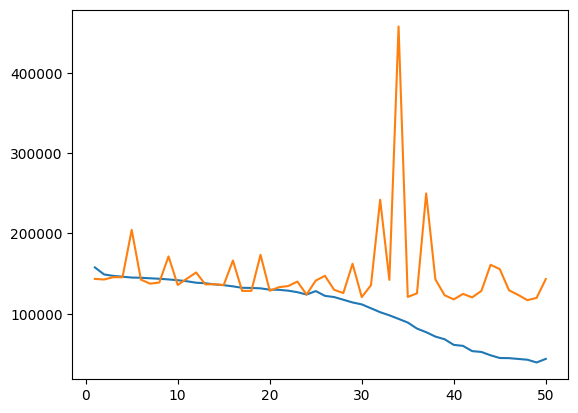

In [10]:
import matplotlib.pyplot as plt

plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")

In [11]:
model_dict ="model/models/best_model.pth"

model.load_state_dict(torch.load(model_dict)["model_state_dict"])

test_pic = "data/isak.jpg"
# plt.imshow(plt.imread(test_pic))

model

C:\Users\isaka\AppData\Local\Temp\ipykernel_18016\3334901755.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_dict)["model_state_di

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc_keypoints): Linear(in

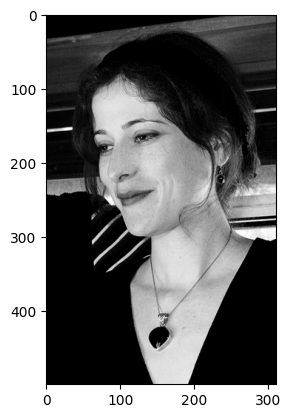

In [12]:
test_prev_pic = '//OMVICECAVE/nas/ml_data/AFLW/annotaded_imgs/image00198.jpg'
plt.imshow(plt.imread(test_prev_pic))
# plt.imshow(plt.imread(test_pic))

In [13]:
test_loader.dataset[0][0].unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [ ]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
criterion = nn.MSELoss()  # Assuming you are using MSELoss for evaluation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():  # Disable gradient calculation
    for data in test_loader.dataset:
        images, keypoints, bboxes = data[0].unsqueeze(0).to(device), data[1].unsqueeze(0).to(device), data[2].unsqueeze(0).to(device)
        outputs_keypoints, outputs_bbox = model(images)
        
        # Reshape outputs_keypoints to match the size of keypoints
        outputs_keypoints = outputs_keypoints.view_as(keypoints)
        
        loss_keypoints = criterion(outputs_keypoints, keypoints)
        loss_bbox = criterion_bbox(outputs_bbox, bboxes)
        loss = loss_keypoints + loss_bbox
        
        test_loss += loss.item() * images.size(0)

test_loss = test_loss / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get an example from the test data
example_data = test_loader.dataset[0]
example_image = example_data[0].unsqueeze(0).to(device)
example_keypoints = example_data[1].to(device)
example_bbox = example_data[2].to(device)

# Set the model to evaluation mode
model.eval()

# Get the model predictions
with torch.no_grad():
    pred_keypoints, pred_bbox = model(example_image)

# Convert predictions to numpy for plotting
pred_keypoints_np = pred_keypoints.cpu().numpy().reshape(-1, 2)
pred_bbox_np = pred_bbox.cpu().numpy().reshape(-1)

# Plot the image
fig, ax = plt.subplots(1)
ax.imshow(example_image.cpu().squeeze().permute(1, 2, 0))

# Plot the predicted keypoints
for (x, y) in pred_keypoints_np:
    ax.plot(x, y, 'ro')

# Plot the predicted bounding box
rect = patches.Rectangle((pred_bbox_np[0], pred_bbox_np[1]), pred_bbox_np[2], pred_bbox_np[3], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.show()

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
model